In [8]:
import jax
import tqdm
import numpy as np 
from jax import lax 
import networkx as nx
from jax import random
from jax import make_jaxpr
from jax import device_put
from jax import numpy as jnp
from jax.config import config
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from jax import grad, jit, vmap, pmap 
config.update("jax_enable_x64", True)
config.update("jax_platform_name", "cpu") 

In [2]:
plt.rcParams['axes.xmargin'] = 0
plt.style.use('seaborn-whitegrid')
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['axes.labelsize'] = 14

In [3]:
def whereis(x):
    print(x.device_buffer.device())

In [4]:
# damp oscillator
def f_sys_numpy(y, t, b, c):
    return np.array([y[1], -b*y[1] - c*np.sin(y[0])])

def f_sys(y, t, b, c):
    return jnp.array([y[1], -b*y[1] - c*jnp.sin(y[0])])

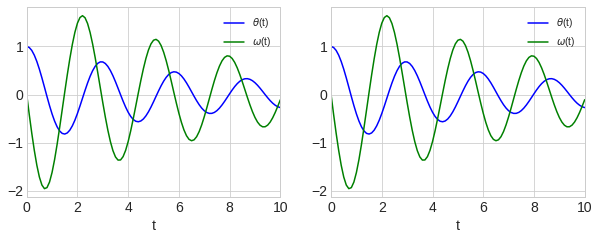

In [5]:
# using numpy
t = np.linspace(0, 10, 101)
y0 = np.array([1.0, 0.0])
b = 0.25
c = 5.0
sol = odeint(f_sys_numpy, y0, t, args=(b, c))


fig, ax = plt.subplots(1, 2, figsize=(10, 3.5))
ax[0].plot(t, sol[:, 0], 'b', label=r'$\theta$(t)')
ax[0].plot(t, sol[:, 1], 'g', label=r'$\omega$(t)')
ax[0].legend(loc='best')
ax[0].set_xlabel('t');

# using jax
t = jnp.linspace(0, 10, 101)
y0 = jnp.array([1.0, 0.0])
b = 0.25
c = 5.0
sol = odeint(jit(f_sys), y0, t, args=(b, c))

ax[1].plot(t, sol[:, 0], 'b', label=r'$\theta$(t)')
ax[1].plot(t, sol[:, 1], 'g', label=r'$\omega$(t)')
ax[1].legend(loc='best')
ax[1].set_xlabel('t');

In [6]:
def rk4_step(y, t, dt, *args):
    k1 = f_sys(y, t, *args)
    k2 = f_sys(y + 0.5*dt*k1, t + 0.5*dt, *args)
    k3 = f_sys(y + 0.5*dt*k2, t + 0.5*dt, *args)
    k4 = f_sys(y + dt*k3, t + dt, *args)
    return y + dt/6.0 * (k1 + 2*k2 + 2*k3 + k4)

def rk4(y0, t, *args):
    y = jnp.zeros((len(t), len(y0)))
    y = y.at[0].set(y0)
    for i in range(len(t) - 1):
        dt = t[i+1] - t[i]
        y = y.at[i+1].set(rk4_step(y[i], t[i], dt, *args))
    return y

In [7]:
t = jnp.linspace(0, 10, 101)
y0 = jnp.array([1.0, 0.0])
b = 0.25
c = 5.0

In [8]:
%timeit sol = rk4(y0, t, b, c)

947 ms ± 39 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
rk4 = jit(rk4, backend='cpu')
f_sys = jit(f_sys, backend='cpu')
rk4_step = jit(rk4_step, backend='cpu')

In [10]:
%timeit sol = rk4(y0, t, b, c)

The slowest run took 7.42 times longer than the fastest. This could mean that an intermediate result is being cached.
45.7 µs ± 43.2 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


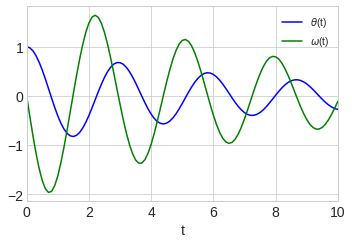

In [11]:
fig, ax = plt.subplots(1, figsize=(5, 3.5))
ax.plot(t, sol[:, 0], 'b', label=r'$\theta$(t)')
ax.plot(t, sol[:, 1], 'g', label=r'$\omega$(t)')
ax.legend(loc='best')
ax.set_xlabel('t')
plt.tight_layout()
plt.show()


In [12]:
def f_sys(x, t, coupling, omega, adj):

    N = x.shape[0]
    dx = jnp.zeros_like(x)

    for i in range(N):
        dx = dx.at[i].set(omega[i] + coupling * jnp.sum(adj[i,:] * jnp.sin(x - x[i])))

    return dx


def order_parameter(theta):
    '''
    calculate the order parameter
    theta : (nsteps, nnodes)
    '''
    
    N = theta.shape[1]
    r = jnp.zeros(len(theta))
    for i in range(len(theta)):
        r = r.at[i].set(jnp.abs(jnp.sum(jnp.exp(1j * theta[i,:])))/N)
    return r

In [13]:
# K = np.arange(0.0, 0.4, 0.01)   # coupling
N = 3                           # number of nodes
K = 1.0
dt = 0.01                       # time step
T = 20.0                       # simulation time
omega_0 = np.random.normal(0, 0.1, N)  # natural frequencies
adj = nx.to_numpy_array(nx.complete_graph(N))  # adjacency matrix
x0 = np.random.uniform(0, 2*np.pi, N)  # initial conditions
t = np.arange(0.0, T, dt)

x0 = device_put(x0)
adj = device_put(adj)
omega = device_put(omega_0)
t = device_put(t)

In [ ]:
# f_sys = jit(f_sys)
# sol = rk4(x0, t, K, omega, adj)

In [ ]:
# r = order_parameter(sol)
# plt.plot(r);

#### [Diffrax](https://docs.kidger.site/diffrax/usage/getting-started/)

In [16]:
# !pip install diffrax

In [4]:
from diffrax import diffeqsolve, ODETerm, Dopri5, SaveAt
import jax.numpy as jnp

def f(t, y, args):
    return -y

term = ODETerm(f)
solver = Dopri5()
y0 = jnp.array([2., 3.])
solution = diffeqsolve(term, solver, t0=0, t1=1, dt0=0.1, y0=y0)

In [11]:
print(solution.ys)

[[0.73575866 1.1036385 ]]


In [12]:
from diffrax import diffeqsolve, Dopri5, ODETerm, SaveAt, PIDController

vector_field = lambda t, y, args: -y
term = ODETerm(vector_field)
solver = Dopri5()
saveat = SaveAt(ts=[0., 1., 2., 3.])
stepsize_controller = PIDController(rtol=1e-5, atol=1e-5)

sol = diffeqsolve(term, solver, t0=0, t1=3, dt0=0.1, y0=1, saveat=saveat,
                  stepsize_controller=stepsize_controller)

print(sol.ts)  # DeviceArray([0.   , 1.   , 2.   , 3.    ])
print(sol.ys)  # DeviceArray([1.   , 0.368, 0.135, 0.0498])

[0. 1. 2. 3.]
[1.         0.36788338 0.13533922 0.04978961]


#### SDE

$$
y(0) = 1 \\
dy(t) = -y(t) dt + \frac{t}{10} dw(t)
$$

In [13]:
import jax.random as jrandom
from diffrax import diffeqsolve, ControlTerm, Euler, MultiTerm, ODETerm, SaveAt, VirtualBrownianTree

t0, t1 = 1, 3
drift = lambda t, y, args: -y
diffusion = lambda t, y, args: 0.1 * t
brownian_motion = VirtualBrownianTree(t0, t1, tol=1e-3, shape=(), key=jrandom.PRNGKey(0))
terms = MultiTerm(ODETerm(drift), ControlTerm(diffusion, brownian_motion))
solver = Euler()
saveat = SaveAt(dense=True)

sol = diffeqsolve(terms, solver, t0, t1, dt0=0.05, y0=1.0, saveat=saveat)
print(sol.evaluate(1.1))  # DeviceArray(0.89436394)


0.8909249612203544
